## Preprocessing and Exploratory Data Analysis

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Import these libraries. These are the necessary libraries for loading and preprocessing the data for deep learning. 

In [4]:
jan_jun_2023_df = pd.read_csv('EIA930_BALANCE_2023_Jan_Jun.csv')
jul_dec_2023_df = pd.read_csv('EIA930_BALANCE_2023_Jul_Dec.csv')
jan_jun_2024_df = pd.read_csv('EIA930_BALANCE_2024_Jan_Jun.csv')

C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\98878754.py:1: DtypeWarning: Columns (5,6,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  jan_jun_2023_df = pd.read_csv('EIA930_BALANCE_2023_Jan_Jun.csv')
C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\98878754.py:2: DtypeWarning: Columns (5,6,7,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  jul_dec_2023_df = pd.read_csv('EIA930_BALANCE_2023_Jul_Dec.csv')
C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\98878754.py:3: DtypeWarning: Columns (10,11,19,21,22,23,25,26,27,29,30,31,36,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  jan_jun_2024_df = pd.read_csv('EIA930_BALANCE_2024_Jan_Jun.csv')


Load in the CSV files as pandas dataframes. One CSV file presents data from January to Jun 2023, the other CSV file contains data from July to December 2023, and lastly the last CSV file contains data from January to March 2024

In [5]:
df = pd.concat([jan_jun_2023_df, jul_dec_2023_df, jan_jun_2024_df], axis = 0).reset_index()

Combine all dataframes into a single dataframe.

In [ ]:
exclude_authority = ['YAD', 'SEPA', 'GLHB', 'DEAA', 'HGMA', 'GRID', 'AVRN', 'GWA', 'WWA', 'GRIF', 'WAUW']
df = df[~df['Balancing Authority'].isin(exclude_authority)]
columns_over_30_percent_missing = [column for column in df.columns if df[column].isnull().sum()/len(df) > .30]
df.drop(columns_over_30_percent_missing, axis = 1, inplace=True)

- Remove Balancing Authorities YAD, SEPA, GLHB, DEAA, HGMA, GRID, AVRN, GWA, WWA,GRIF, and WAUW because these Balancing authority classes contain long periods of missing net generation data.
- Remove columns where the percentage missing values are greater than 30%

In [6]:
for i in df.iloc[:,6:20].columns:
    if df[i].str.contains(',').any():
        df[i] = df[i].str.replace(',', '')
        df[i] = df[i].astype('float64')
    else:
        df[i] = df[i].astype('float64')    

Some values are strings because their comma, so you have to convert them to float by first removing the commas, and convert them to a float

In [7]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset
corr_removed_df = correlation(df.select_dtypes(include='float64'), .90)
uncorrelated_features = corr_removed_df.columns.to_list()
non_float_features = df.select_dtypes(exclude='float').columns.to_list()
df = pd.concat([df[non_float_features],df[uncorrelated_features]], axis = 1)

Keep only one correlated column out of a group of highly correlated column, correlation coefficient that is greater than or equal to 90 is considered highly correlated.  

In [8]:
df = df.sort_values(by = 'UTC Time at End of Hour')
df = df.sort_values(by=['Balancing Authority', 'UTC Time at End of Hour'])

Sort the dataframe by balancing authority and UTC time

In [9]:
for columns in df.columns: 
    df[columns] = df[columns].interpolate(method = 'linear')
df['Net Generation (MW) from Hydropower and Pumped Storage'] = df['Net Generation (MW) from Hydropower and Pumped Storage'].bfill()
df['Net Generation (MW) from Solar'] = df['Net Generation (MW) from Solar'].bfill()


Perform linear interpolation for handle majority of the missing data. Then use backfill for the remaining missing. 

In [10]:
reigon_mapping = {'NW': 'Idaho', 'FLA': 'Florida', 'SW': 'Arizona', 'CAL': 'California', 'MIDW': 'Ohio', 'CENT': 'Kansas', 'TEX': 'Texas', 'NE':'Connecticut', 'NY': 'New York', 'MIDA': 'Pennsylvania', 'SE': 'Georgia', 'TEN': 'Tennessee', 'CAR': 'North Carolina'}
df['State_Rep_Region'] = df['Region'].map(reigon_mapping)
# importing geopy library
from geopy.geocoders import Nominatim

# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")

# entering the location name
longitude_mapping = {'Idaho': loc.geocode('Idaho').longitude, 'Florida': loc.geocode('Florida').longitude, 'Arizona': loc.geocode('Arizona').longitude, 'California': loc.geocode('California').longitude, 'Ohio':loc.geocode('Ohio').longitude,
  'Kansas': loc.geocode('Kansas').longitude, 'Texas': loc.geocode('Texas').longitude, 'Connecticut': loc.geocode('Connecticut').longitude, 'New York': loc.geocode('New York').longitude, 'Pennsylvania': loc.geocode('Pennsylvania').longitude, 
  'Georgia': loc.geocode('Atlanta').longitude, 'Tennessee': loc.geocode('Tennessee').longitude, 'North Carolina': loc.geocode('North Carolina').longitude}
latitude_mapping = {'Idaho': loc.geocode('Idaho').latitude, 'Florida': loc.geocode('Florida').latitude, 'Arizona': loc.geocode('Arizona').latitude, 'California': loc.geocode('California').latitude, 'Ohio':loc.geocode('Ohio').latitude,
  'Kansas': loc.geocode('Kansas').latitude, 'Texas': loc.geocode('Texas').latitude, 'Connecticut': loc.geocode('Connecticut').latitude, 'New York': loc.geocode('New York').latitude, 'Pennsylvania': loc.geocode('Pennsylvania').latitude, 
  'Georgia': loc.geocode('Atlanta').latitude, 'Tennessee': loc.geocode('Tennessee').latitude, 'North Carolina': loc.geocode('North Carolina').latitude}
df['Longitude'] = df['State_Rep_Region'].map(longitude_mapping)
df['Latitude'] = df['State_Rep_Region'].map(latitude_mapping)

Assign a state per region, then calculate the longitude and latitude for the selected state per region. Created a longitude column and latitude column based on the longitude and latitude of the selected state per region.

In [11]:
df['UTC Time at End of Hour'] = pd.to_datetime(df['UTC Time at End of Hour'])
df['Week Number'] = df['UTC Time at End of Hour'].dt.isocalendar().week
df['UTC Hour'] = df['UTC Time at End of Hour'].dt.hour


Make the UTC time a pandas DataTime column, then extract the week number and Hour from UTC Time.

In [12]:
import numpy as np
for term in range(2):
    df[f'Week_number_sin{term + 1}'] = np.sin(2 * np.pi * df['Week Number']/ df['Week Number'].max())
    df[f'Week_number_cos{term +1}'] = np.cos(2 * np.pi * df['Week Number']/ df['Week Number'].max())
for term in range(2):
    df[f'Hour_Number_sin{term + 1}'] = np.sin(2 * np.pi * df['UTC Hour']/ df['UTC Hour'].max())
    df[f'Hour_Number_cos{term +1}'] = np.cos(2 * np.pi * df['UTC Hour']/ df['UTC Hour'].max())
for lag in range(5):
    df[f'Demand_lag{lag +1}'] = df['Demand (MW)'].shift(lag)
df = df.sort_values(by='Balancing Authority')
sixty_day_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24*60).mean()
df['ewma_sixty_day_span'] = sixty_day_span
weekly_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24*7).mean()
df['ewma_weekly_span'] = weekly_span

- Create fourier terms based on the week number and the hour number.
- Create lag columns ranging from 1 to 6 time steps for the Demand column
- Create column for the weekly, 60 day, daily, biweekly, biannual and hourly ewma of the demand column

In [13]:
daily_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24*7).mean()
df['ewma_daily_span'] = daily_span
biweekly_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24*14).mean()
df['ewma_biweekly_span'] = biweekly_span
biannual_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24*182).mean()
df['ewma_biannual_span'] = biannual_span
hourly_span = df.groupby(by = 'Balancing Authority')['Demand (MW)'].shift(1).ewm(span= 24).mean()
df['ewma_hourly_span'] = hourly_span

In [14]:
df = df.set_index('UTC Time at End of Hour')

Set the dataframe index to UTC TIme to make indexing based off time easier

In [15]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(df['Demand (MW)'])
print('P-value for Stationary:', res[1])

P-value for Stationary: 5.354957852115871e-13


Check if Demand column is stationary by calculating the p-value of adfuller

In [ ]:
df = df.sort_index()

Sort index in descending time order.

In [19]:
columns_to_drop = ['index', 'Balancing Authority', 'Data Date', 'Hour Number', 'Local Time at End of Hour', 'Region', 'Demand Forecast (MW)', 
                   'State_Rep_Region', 'Week Number']
ml_df = df.copy()


Remove these columns because they will not used as inputs when running the deep learning model

In [20]:
ml_df.drop(columns_to_drop,axis = 1, inplace = True)


In [21]:
horizon = df['UTC Hour'].nunique() * df['Balancing Authority'].nunique()
ml_df['Demand_Shifted'] = ml_df['Demand (MW)'].shift(-horizon)
print('Forecast Horizon/Time steps:', horizon)

Forecast Horizon/Time steps: 1248


Calculate the forecast horizon where the number of unique hour numbers are  multiplied by the number of unique balancing authorities. We want to forecast the hourly demand for all balancing authorities for 24 hours. 
Shift the demand column up by the amount of the forecast horizon to avoid data leakage

In [22]:
import tensorflow

In [23]:
time_steps = df['Balancing Authority'].nunique() * df['UTC Hour'].nunique()

In [24]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))
def to_seq2seq_dataset(series, seq_length=168, ahead=1300, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tensorflow.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

These two functions will create a tuple where in the inputs are columns from the previous time step, and target is the demand for the next time step

In [26]:
tf_ml_df = ml_df.drop('Demand (MW)', axis =1)

drop Demand column because we are going to be using the demand column that was shifted by the horizon amount.

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tf_ml_df = pd.DataFrame(scaler.fit_transform(tf_ml_df), columns = tf_ml_df.columns)

Scale the the inputs and target columns for faster convergence when performing the deep learning algorithm

In [28]:
tf_ml_df = tf_ml_df.dropna()
tf_ml_df.drop('UTC Hour',axis = 1, inplace = True)
seq_length = df['Balancing Authority'].nunique() * 3
test_multistep = tf_ml_df.values[-time_steps:]
print('Sequence Length:', seq_length)

Sequence Length: 156


Drop the missing values of the demand shift column, this happened because demand was shifted up by the horizon amount. Next, the window length for the deep learning algorithm will be a 3 hour window for all balancing authorities. Lastly, the inputs of the last 1248 rows (equivalent to forecast horizon) will be the testing features.

In [29]:
seq2seq_train = to_seq2seq_dataset(np.asarray(tf_ml_df.values[:-time_steps]).astype(np.float32), seq_length=seq_length, ahead=time_steps, target_col=tf_ml_df.columns.get_loc('Demand_Shifted'))

all but the last 1248 time steps will be subsetted as training. The window size is the 3 hour window for all of the balancing authorities. And We are trying to predict the next 1248 time steps for each window

In [30]:
import tensorflow
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import Huber

lstm_input = Input(shape = [None, tf_ml_df.shape[1]])
lstm_x = LSTM(32, return_sequences = True)(lstm_input)
lstm_x = Dropout(0.3)(lstm_x)
lstm_x= Dense(2000, activation = 'relu')(lstm_x)
lstm_x = Dropout(0.3)(lstm_x)
lstm_output = Dense(time_steps)(lstm_x)

multi_step_lstm_model = Model(lstm_input, lstm_output)
multi_step_lstm_model.compile(optimizer = 'adam', loss = Huber(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
multi_step_lstm_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 26)]        0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          7552      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 2000)        66000     
                                                                 
 dropout_1 (Dropout)         (None, None, 2000)        0         
                                                                 
 dense_1 (Dense)             (None, None, 1248)        2497248   
                                                                 
Total params: 2570800 (9.81 MB)
Trainable params: 2570800 (

An LSTM model which consists of a LSTM  with 32 lstm units layer  followed by a dropout layer, then followed by a feedforward network of 2000 neurons, which is then followed by another dropout layer. And lastly the final output is a feedfoward layer that outputs the forecast horizon values.

In [31]:
ml_df.dropna(inplace=True)
demand_scaler = StandardScaler()
demand_scaled = demand_scaler.fit_transform(ml_df['Demand_Shifted'].values[-time_steps:].reshape(-1,1))

Obtain the scaled values of the demand shifted columns to be to unscale to output of the lstm model.

In [32]:
multi_step_lstm_model.fit(seq2seq_train, epochs = 5, shuffle=False)

Epoch 1/5

17583/17583 [==============================] - 6103s 347ms/step - loss: 0.2943 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.5508
Epoch 2/5
17583/17583 [==============================] - 5961s 339ms/step - loss: 0.2942 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.5507
Epoch 3/5
17583/17583 [==============================] - 5977s 340ms/step - loss: 0.2942 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.5507
Epoch 4/5
17583/17583 [==============================] - 6075s 345ms/step - loss: 0.2942 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.5507
Epoch 5/5
17583/17583 [==============================] - 6132s 349ms/step - loss: 0.2942 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.5507


Train the model for 5 epochs

In [33]:
seq2seqx = test_multistep[np.newaxis, :seq_length]
y_pred = multi_step_lstm_model.predict(seq2seqx)[0, -1]
unscaled_y_pred = demand_scaler.inverse_transform(np.array(y_pred).reshape(-1,1))


1/1 [==============================] - 1s 748ms/step


extract the predicted last 1248 timesteps,and unscale the predicted values based on the shifted demand column.

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model_dict = {}
forecast_rmse = np.sqrt(mean_squared_error(ml_df['Demand (MW)'].values[-time_steps:],df['Demand Forecast (MW)'].values[-time_steps:]))
forecast_mae = mean_absolute_error(ml_df['Demand (MW)'].values[-time_steps:],df['Demand Forecast (MW)'].values[-time_steps:])
model_dict['Demand Forecast'] = [forecast_rmse, forecast_mae]
multi_step_lstm_rmse = np.sqrt(mean_squared_error(ml_df['Demand (MW)'].values[-time_steps:], unscaled_y_pred))
multi_step_lstm_mae = mean_absolute_error(ml_df['Demand (MW)'].values[-time_steps:], unscaled_y_pred)
model_dict['Multi-Step_LSTM'] = [multi_step_lstm_rmse, multi_step_lstm_mae]

Our baseline model will be the EIA's Demand Forecast column. We will calculate the root mean squared error and mean absolute error for EIA's Demand Forecast, and the LSTM's predicted output. 
Then we will put these values into a dictionary 

In [65]:
multi_step_pred_dict = {}
multi_step_pred_dict['Multi LSTM'] = list(np.array(unscaled_y_pred).flatten())
multi_step_pred_dict['Demand Forecast'] = df['Demand Forecast (MW)'].values[-time_steps:]
multi_step_pred_dict['Actual'] = ml_df['Demand (MW)'].values[-time_steps:]
multi_step_pred_df = pd.DataFrame(multi_step_pred_dict, index = ml_df['Demand (MW)'][-time_steps:].index)
multi_step_pred_df['Balancing Authority'] = df['Balancing Authority'].values[-time_steps:]
texas_df = multi_step_pred_df[multi_step_pred_df['Balancing Authority'] == 'ERCO']
texas_multistep_lstm_rmse = np.sqrt(mean_squared_error(texas_df['Actual'], texas_df['Multi LSTM']))
texas_multistep_lstm_mae = mean_absolute_error(texas_df['Actual'], texas_df['Multi LSTM'])
model_dict['ERCO Multi LSTM'] = [texas_multistep_lstm_rmse, texas_multistep_lstm_mae]
texas_forecast_rsme = np.sqrt(mean_squared_error(texas_df['Actual'], texas_df['Demand Forecast']))
texas_forecast_mae = mean_absolute_error(texas_df['Actual'], texas_df['Demand Forecast'])
model_dict['ERCO Demand Forecast'] = [texas_forecast_rsme, texas_forecast_mae]

Create a dictionary that stores all the predicted of the 1248 time steps for the lstm model and the demand forecast, also store the actual values as well. Then convert it into a pandas dataframe. Next create a dataframe that extracts the balancing authority ERCO and its predicted and actual values. ERCO is the balancing authority for Texas. 

In [66]:
model_df = pd.DataFrame(model_dict.values(), columns=['RMSE', 'MAE'])
model_df['Model Name'] = model_dict.keys()

Convert the dictionary that contains the rmse and mae scores into a pandas dataframe. 

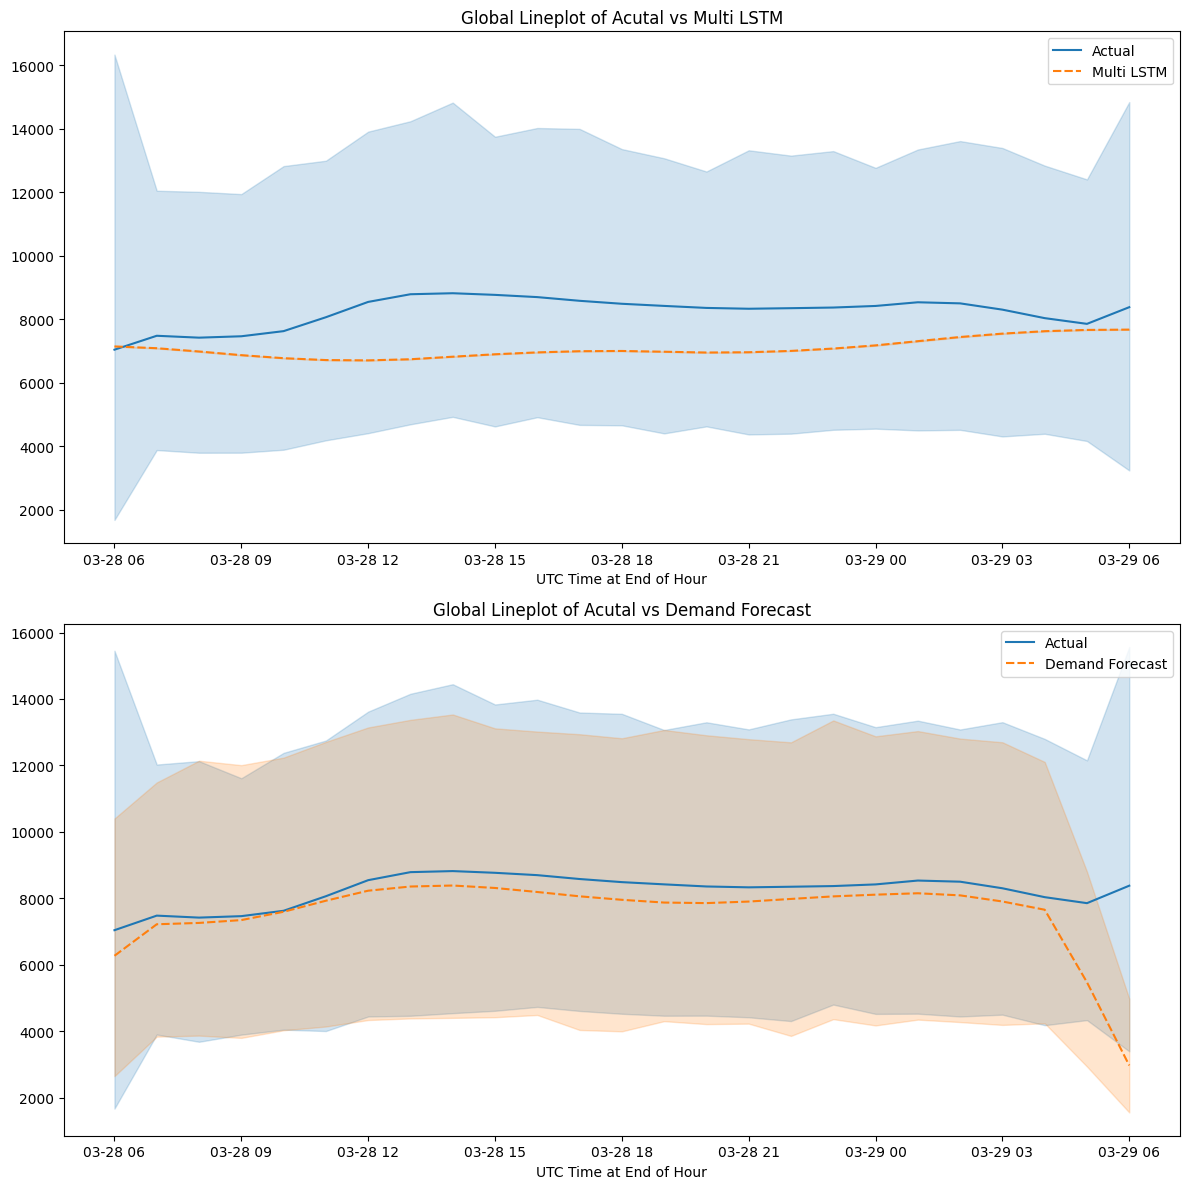

In [53]:
_, axes = plt.subplots(2,1, figsize = (12,12))
axes_flatten = axes.flatten()
for i, column in enumerate(multi_step_pred_df.iloc[:, 0:2].columns):
    sns.lineplot(data = multi_step_pred_df[['Actual', column]], ax=axes_flatten[i])
    axes_flatten[i].set_title(f'Global Lineplot of Acutal vs {column}')
plt.tight_layout()
plt.show()

Display 2 lineplots one compare the last 24 hours of lstm's predicted demand vs actual demand. The one there lineplot compares the last 24 hours of eia's forecast demand vs actual demand. Both of these are on a global scale.  

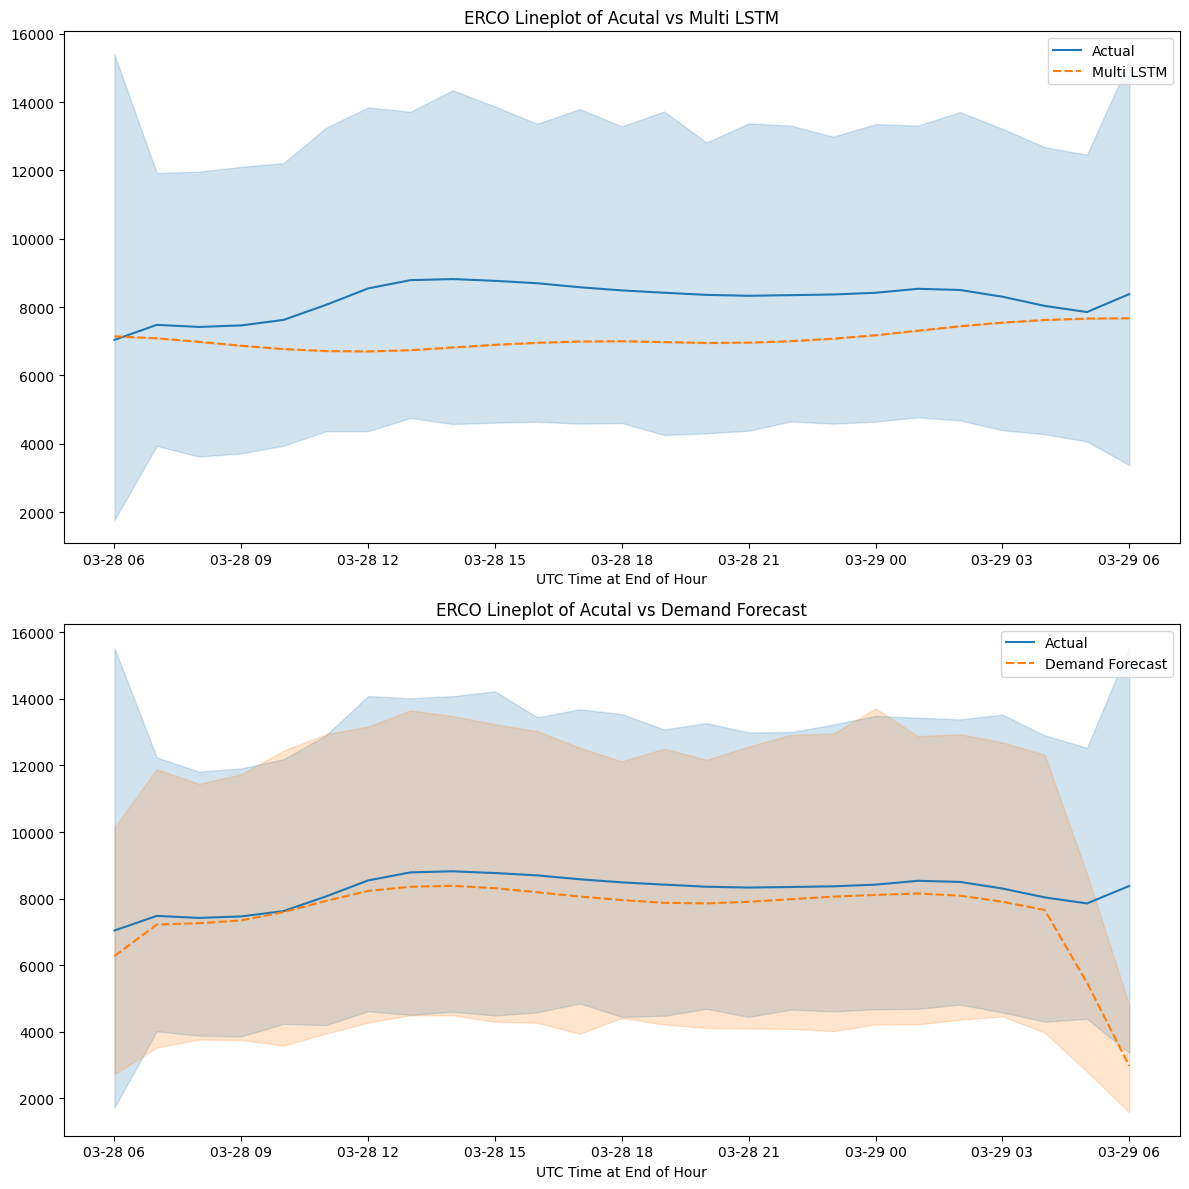

In [54]:
_, axes = plt.subplots(2,1, figsize = (12,12))
axes_flatten = axes.flatten()
for i, texas_column in enumerate(texas_df.iloc[:, 0:2].columns):
    sns.lineplot(data = multi_step_pred_df[['Actual', texas_column]], ax=axes_flatten[i])
    axes_flatten[i].set_title(f'ERCO Lineplot of Acutal vs {texas_column}')
plt.tight_layout()
plt.show()

Display 2 lineplots one compare the last 24 hours of lstm's predicted demand vs actual demand. The one there lineplot compares the last 24 hours of eia's forecast demand vs actual demand. Both of these are based on the ERCO balancing authority. 

Global Average Predicted Value: 
 Multi LSTM         7070.891113
Demand Forecast    7664.923077
Actual             8253.513374
dtype: float64


C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\781025561.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Global Average Predicted Value:','\n', multi_step_pred_df.mean())


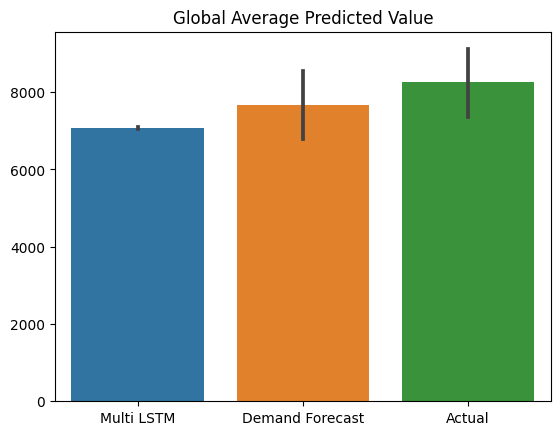

In [57]:
sns.barplot(multi_step_pred_df)
plt.title('Global Average Predicted Value')
print('Global Average Predicted Value:','\n', multi_step_pred_df.mean())

This displays the average predicted value lstm model, EIA's forecast and the actual demand foercast for the last 24 hours globally.

ERCO Average Predicted Value: 
 Multi LSTM          7056.466797
Demand Forecast    43400.826087
Actual              7679.282609
dtype: float64


C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\1864655419.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('ERCO Average Predicted Value:','\n', texas_df.mean())


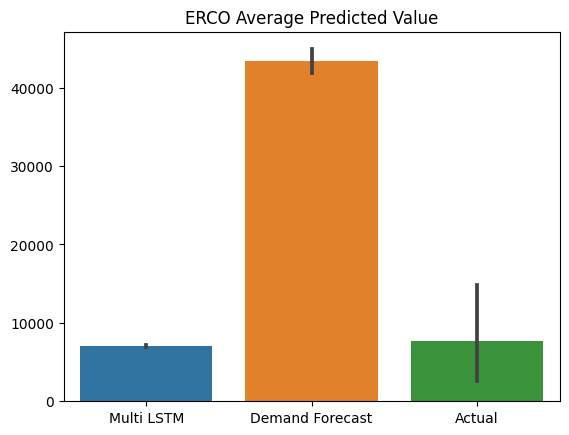

In [78]:
sns.barplot(texas_df)
plt.title('ERCO Average Predicted Value')
print('ERCO Average Predicted Value:','\n', texas_df.mean())

This displays the average predicted value lstm model, EIA's forecast and the actual demand foercast for the last 24 hours for ERCO.

Multi LSTM         6987.564453
Demand Forecast    2217.000000
Actual             2346.000000
dtype: float64


C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\3040102476.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_values = multi_step_pred_df.median().reset_index()
C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\3040102476.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(multi_step_pred_df.median())


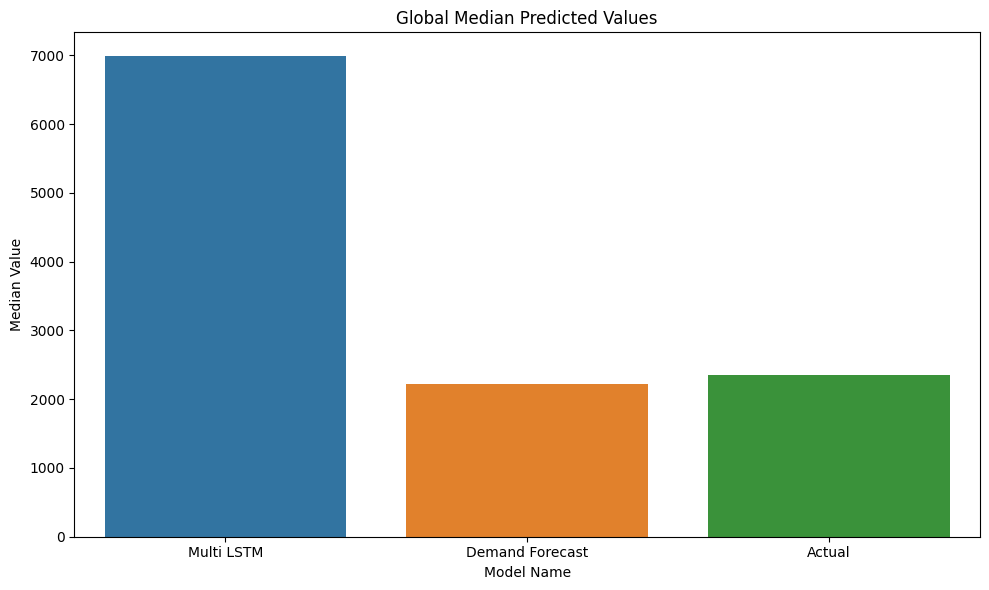

In [76]:
median_values = multi_step_pred_df.median().reset_index()
median_values.columns = ['Model Name', 'Median Value']
print(multi_step_pred_df.median())
plt.figure(figsize=(10, 6))
sns.barplot(data=median_values, x='Model Name', y='Median Value')
plt.title('Global Median Predicted Values')
plt.ylabel('Median Value')
plt.tight_layout()
plt.show()

This displays the median predicted value lstm model, EIA's forecast and the actual demand foercast for the last 24 hours globally.

Multi LSTM          6996.539551
Demand Forecast    44241.000000
Actual              1386.000000
dtype: float64


C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\655347068.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  texas_median_values = texas_df.median().reset_index()
C:\Users\dgmur\AppData\Local\Temp\ipykernel_22000\655347068.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(texas_df.median())


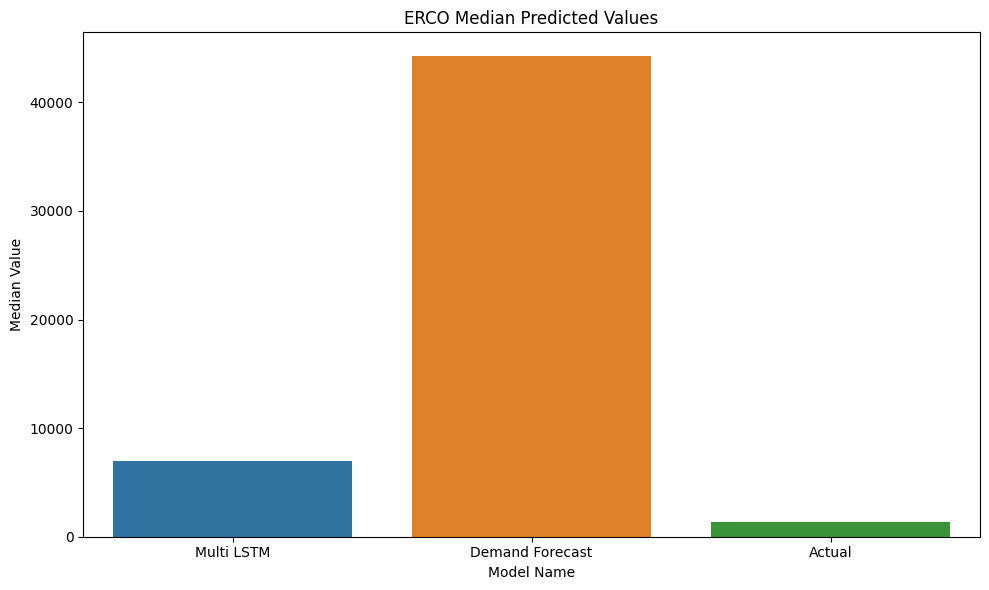

In [77]:
texas_median_values = texas_df.median().reset_index()
texas_median_values.columns = ['Model Name', 'Median Value']
print(texas_df.median())
plt.figure(figsize=(10, 6))
sns.barplot(data=texas_median_values, x='Model Name', y='Median Value')
plt.title('ERCO Median Predicted Values')
plt.ylabel('Median Value')
plt.tight_layout()
plt.show()

This displays the median predicted value lstm model, EIA's forecast and the actual demand foercast for the last 24 hours for ERCO.

             Model Name          RMSE
0       Demand Forecast  22221.459310
1       Multi-Step_LSTM  16469.614353
2       ERCO Multi LSTM  15700.406484
3  ERCO Demand Forecast  38683.015230


Text(0.5, 1.0, 'RMSE of Models')

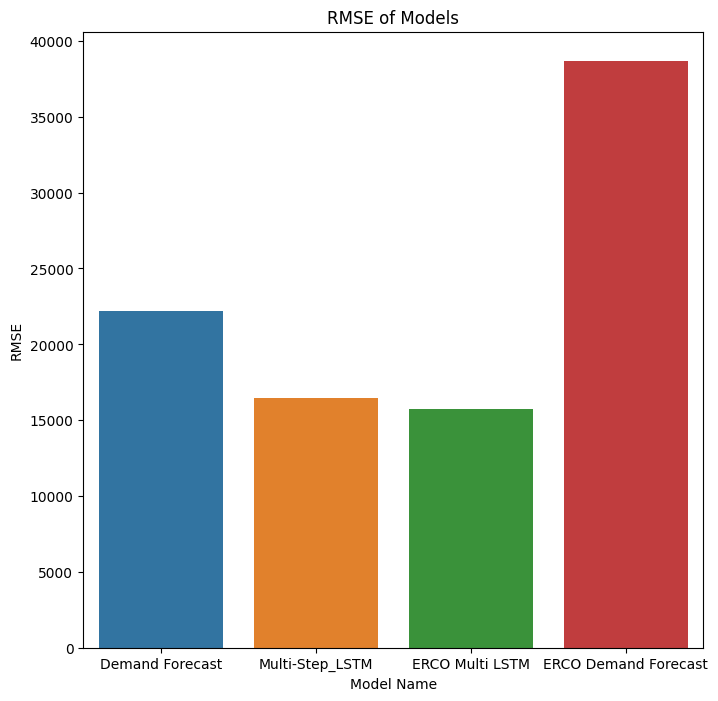

In [70]:
print(model_df[['Model Name', 'RMSE']])
plt.figure(figsize=(8,8))
sns.barplot(data = model_df, x = 'Model Name', y = 'RMSE')
plt.title("RMSE of Models")

This displays all the rmse scores for all of the models globally and locally (ERCO).

             Model Name           MAE
0       Demand Forecast  11570.180696
1       Multi-Step_LSTM   9092.399336
2       ERCO Multi LSTM   9324.503715
3  ERCO Demand Forecast  37254.847826


Text(0.5, 1.0, 'MAE of Models')

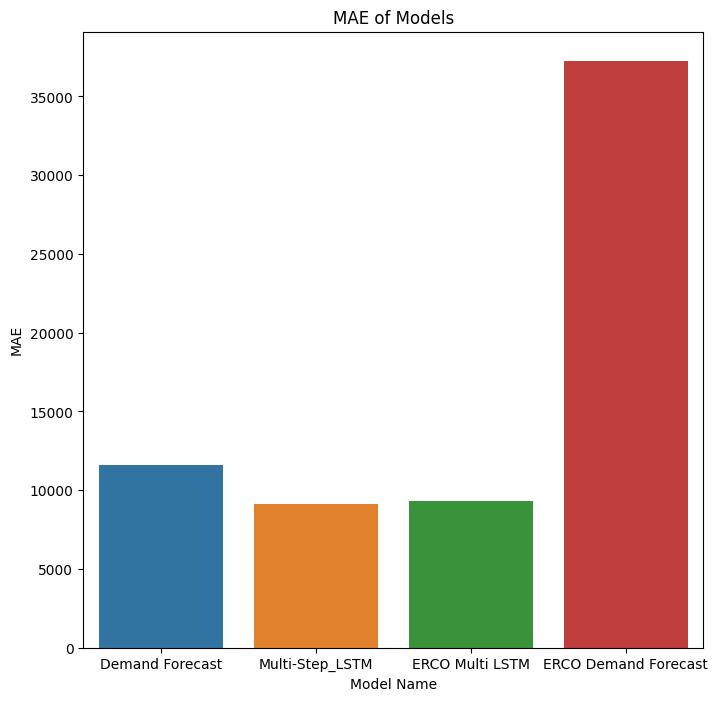

In [69]:
print(model_df[['Model Name', 'MAE']])
plt.figure(figsize=(8,8))
sns.barplot(data = model_df, x = 'Model Name', y = 'MAE')
plt.title("MAE of Models")

This displays all the mae scores for all of the models globally and locally (ERCO).